# Optimize MOOC learner pathways

In this section, we propose a learning item recommendation system based on
consensus clustering (MultiCons) and collaborative filtering.

The approach consists of first grouping learners into homogeneous groups based on
their profile and learning activities in the course using consensus clustering.

Then, for each student cluster, collaborative filtering is applied to recommend
previously unexplored learning items.

We measure the quality of our approach by first training a decision tree classifier
predicting certification success, then comparing changes in success predictions when
students whose failure had previously been correctly predicted follow the
recommendations.

Finally, we compare the quality of our approach to a baseline method that applies
collaborative filtering on the full dataset.

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from sklearn.cluster import OPTICS, AgglomerativeClustering, Birch, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from surprise import Dataset, KNNWithMeans, Reader
from surprise.model_selection import GridSearchCV as SupGridSearchCV

from multicons import MultiCons

from oulad import filter_by_module_presentation, get_oulad

%load_ext oulad.cache

## Preparing the dataset

In this section we:
 - Load the OULAD dataset
 - Select a subset related to a course session
 - Prepare the student interaction and student profile feature tables

### Loading OULAD

In [2]:
%%cache oulad
oulad = get_oulad()

### Selecting one course session

We start by selecting one OULAD course session.

We choose the `BBB` course from the `2013J` session.

In [3]:
CODE_MODULE = "BBB"
CODE_PRESENTATION = "2013J"

#### The `student_item` table

It represents all student interactions with course items of the selected course
session.

In [4]:
%%cache -ns optimize_mooc_learner_pathways student_registration student_item
student_registration = (
    filter_by_module_presentation(
        oulad.student_registration, CODE_MODULE, CODE_PRESENTATION
    )
    # Remove students that unregistered before the course started.
    .query("~(date_unregistration < 0)")
    .drop(["date_unregistration"], axis=1)
    .set_index("id_student")
)

student_item = (
    filter_by_module_presentation(oulad.student_vle, CODE_MODULE, CODE_PRESENTATION)
    .query("id_student in @student_registration.index")
    .drop(["date"], axis=1)
    .groupby(["id_site", "id_student"])
    .sum()
    .reset_index()
    # We convert the `id_site` column to string type as the values of `id_site` will
    # be used as column names in the `student_profile` table.
    # student_item.id_site = student_item.id_site.astype(str)
    .astype({"id_site": str, "sum_click": float})[
        ["id_student", "id_site", "sum_click"]
    ]
)
display(student_item)

,id_student,id_site,sum_click
0,23798,703721,169.0
1,27759,703721,123.0
2,30091,703721,229.0
3,31014,703721,130.0
4,31849,703721,336.0
...,...,...,...
67312,2400851,704240,2.0
67313,2464683,704240,2.0
67314,2512392,704240,1.0
67315,2638818,704240,1.0


#### The `student_profile` table

It contains student demographic data along with course registration information,
course item interactions, and the final result.

It also lets us identify students that have no interaction records or have
unregistered before the course started, which we exclude.

We consider students marked with a final result of `Withdrawn` and `Fail` as failed
and students marked with `Pass` or `Distinction` as succeded.

Finally, we encode all ordinal categorical values to nummerical values.

In [5]:
student_activity = student_item.pivot_table(
    values="sum_click",
    index="id_student",
    columns="id_site",
    fill_value=0.0,
)
student_profile = (
    filter_by_module_presentation(oulad.student_info, CODE_MODULE, CODE_PRESENTATION)
    .set_index("id_student")
    .drop(["num_of_prev_attempts", "region"], axis=1)
    .join(student_registration, how="inner")
    .join((student_activity > 0).astype(float), how="inner")
    .fillna(0.0)
    .replace(
        {
            "age_band": {"0-35": 0.0, "35-55": 0.5, "55<=": 1.0},
            "disability": {"N": 0.0, "Y": 1.0},
            "gender": {"M": 0.0, "F": 1.0},
            "highest_education": {
                "No Formal quals": 0.0,
                "Lower Than A Level": 0.25,
                "A Level or Equivalent": 0.5,
                "HE Qualification": 0.75,
                "Post Graduate Qualification": 1.0,
            },
            "imd_band": {
                # Using 0.0 instead of np.nan as NA's have been filled with zeros.
                0.0: 0.0,
                "0-10%": 5.0,
                # The OULAD data set is missing the `%` in the `10-20` imd_band.
                "10-20": 15.0,
                "20-30%": 25.0,
                "30-40%": 35.0,
                "40-50%": 45.0,
                "50-60%": 55.0,
                "60-70%": 65.0,
                "70-80%": 75.0,
                "80-90%": 85.0,
                "90-100%": 95.0,
            },
            "final_result": {
                "Withdrawn": False,
                "Fail": False,
                "Pass": True,
                "Distinction": True,
            },
        }
    )
)
display(student_profile)

,gender,highest_education,imd_band,age_band,studied_credits,disability,final_result,date_registration,703721,703722,...,704231,704232,704233,704234,704235,704236,704237,704238,704239,704240
id_student,,,,,,,,,,,,,,,,,,,,,
23798,0.0,0.50,55.0,0.0,60,0.0,True,-27.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27759,0.0,0.25,45.0,0.5,120,1.0,False,-43.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30091,1.0,0.50,15.0,0.0,60,1.0,True,-145.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31014,1.0,0.25,85.0,0.5,120,0.0,False,-43.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31849,1.0,0.25,65.0,0.5,120,0.0,True,-128.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680344,1.0,0.75,85.0,0.5,60,0.0,True,-25.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2680885,1.0,0.25,55.0,0.0,60,1.0,True,-141.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2691100,1.0,0.25,5.0,0.0,120,0.0,True,-141.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train/Test split

In this section we split the `student_profile` table into training and
testing sets and standartize feature values.

In [6]:
RANDOM_STATE = 0
feature_table = student_profile.drop(["final_result"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(
    feature_table,
    student_profile.final_result,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

## Final result prediction

Next, we train a decision tree model to predict the student `final_result` outcome.
The model will be used at the final step to evaluate the quality of the
recommendations.

#### Decision Tree

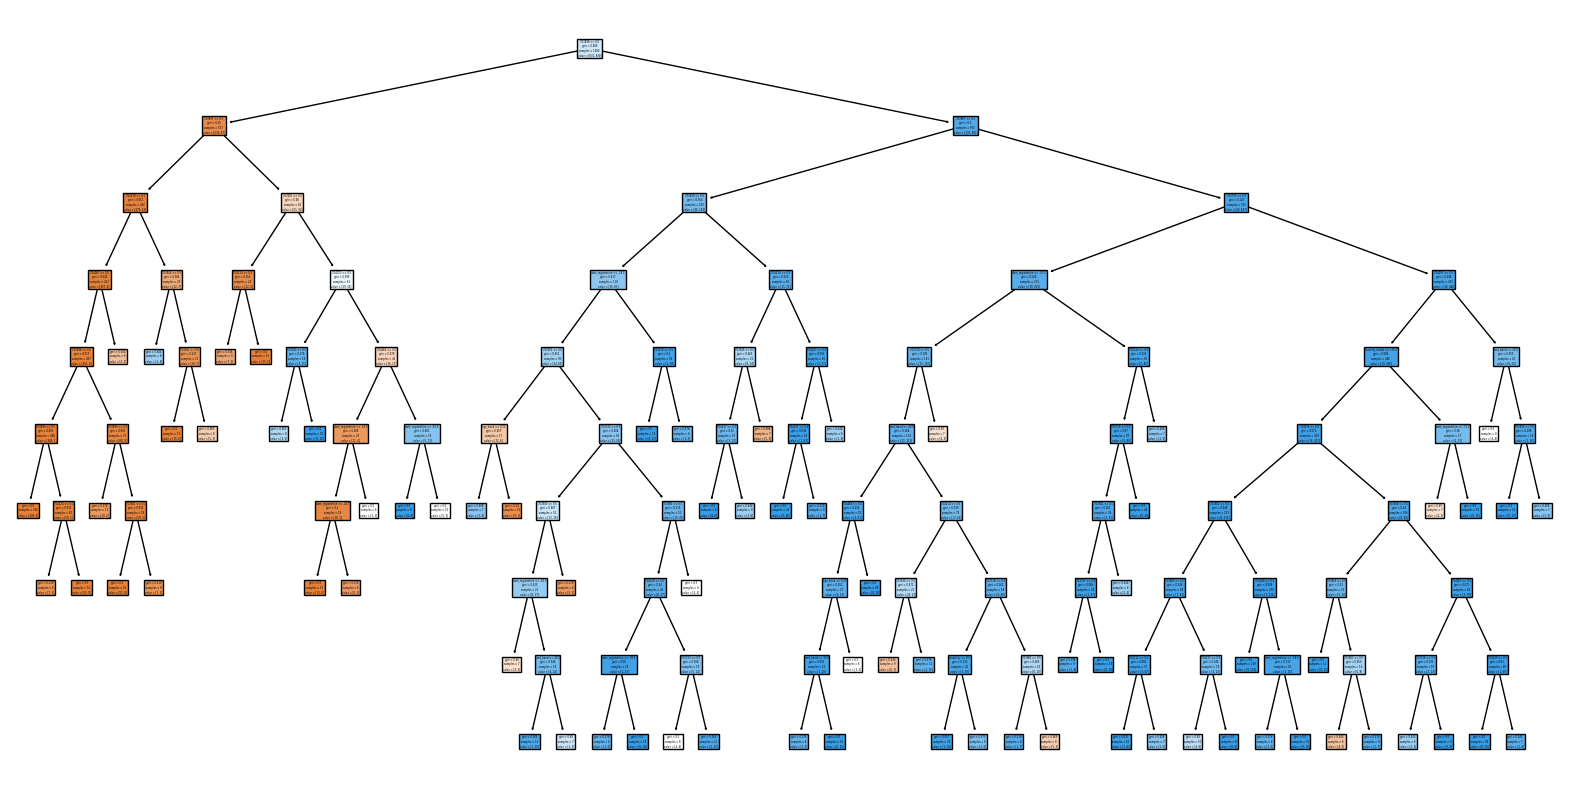

Precision: 0.8475

Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 13, 'random_state': 0, 'splitter': 'best'}

Out of 147 failing students, the model predicted correctly 113 failing students (76.87%)

In [7]:
%%cache -ns optimize_mooc_learner_pathways gs_classifier
# Hyperparameter search space
hyperparameters = {
    "criterion": ["gini"],  # ["gini", "entropy", "log_loss"],
    "splitter": ["best"],  # ["random", "best"],
    "max_depth": [9],  # [None, *list(range(1, 20))],
    "min_samples_split": [13],  # range(2, 20),
    "min_samples_leaf": [6],  # range(1, 20),
    "random_state": [RANDOM_STATE],
}

# Train Decision tree
gs_classifier = GridSearchCV(
    DecisionTreeClassifier(),
    hyperparameters,
    scoring="precision",
    n_jobs=-1,
    error_score="raise",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
).fit(x_train, y_train)

display(Markdown("#### Decision Tree"))
plt.figure(figsize=(20, 10))
plot_tree(
    gs_classifier.best_estimator_,
    feature_names=x_train.columns.values.tolist(),
    filled=True,
)
plt.show()

display(Markdown(f"Precision: {gs_classifier.score(x_test, y_test):.4f}"))
display(Markdown(f"Decision Tree Parameters: {gs_classifier.best_params_}"))
predictions = gs_classifier.predict(x_test)
display(
    Markdown(
        f"Out of {(~y_test).sum()} failing students, the model predicted "
        f"correctly {(~predictions[~y_test]).sum()} failing students "
        f"({100 * (~predictions[~y_test]).sum() / (~y_test).sum():.2f}%)"
    )
)

## Consensus clustering

### Base clusterings

At this stage we train our base clustering models which will be used in the MultiCons
Consensus algorithm.

'MultiCons: selected merging_threshold=0.5 with score: 0.39'

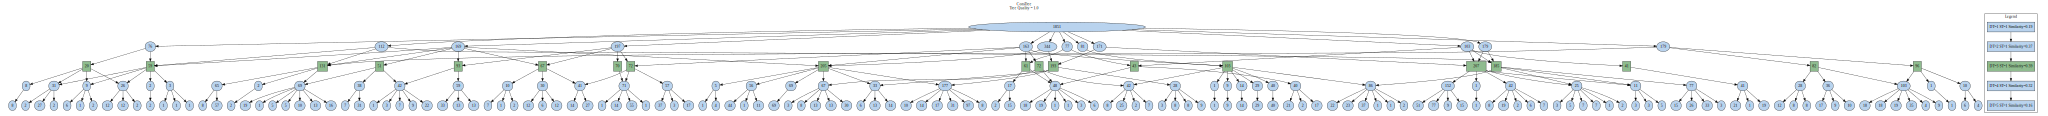

0
multicons final_result     
0         False          15
          True            5
1         False           9
          True           34
2         False          24
          True           17
3         False          31
          True           28
4         False          24
          True           27
5         False          19
          True           42
6         False          33
          True           39
7         False          16
          True           54
8         False          32
          True           50
9         False          24
          True           48
10        False          32
          True           35
11        False          36
          True           67
12        False          56
          True           37
13        False          55
          True           41
14        False          53
          True           78
15        False          52
          True          133
16        False          92
          True          101
17        False          78
          True          129
18        False          98
          True          107

In [15]:
%%cache -ns optimize_mooc_learner_pathways base_clusterings consensus
base_clusterings = [
    KMeans(
        n_clusters=18, max_iter=4000, n_init="auto", random_state=RANDOM_STATE
    ).fit_predict(feature_table),
    AgglomerativeClustering(n_clusters=19).fit_predict(feature_table),
    GaussianMixture(n_components=19, random_state=RANDOM_STATE).fit_predict(
        feature_table
    ),
    Birch(n_clusters=8, threshold=0.3).fit_predict(np.ascontiguousarray(feature_table)),
    OPTICS(min_samples=11).fit_predict(feature_table),
]


def search_best_merging_threshold(clusterings, mt_range):
    """Loops over mt_range and returns the most similar fitted MultiCons instance."""
    max_score = 0
    selected_consensus = None
    for merging_threshold in mt_range:
        multicons = MultiCons(
            consensus_function="consensus_function_12",
            merging_threshold=merging_threshold,
        ).fit(clusterings)
        score = multicons.ensemble_similarity[multicons.recommended]
        if score > max_score:
            max_score = score
            selected_consensus = multicons
    return selected_consensus


consensus = search_best_merging_threshold(base_clusterings, [0.5, 0.75])
display(
    f"MultiCons: selected merging_threshold={consensus.merging_threshold} "
    f"with score: {consensus.ensemble_similarity[consensus.recommended]:0.2f}"
)
display(consensus.cons_tree())
display(
    pd.DataFrame(
        {"multicons": consensus.labels_, "final_result": student_profile.final_result}
    )
    .groupby(["multicons", "final_result"])
    .size()
    .to_frame()
)

## Collaborative filtering

Next, for each consensus group we train a collaborative filtering model.

In [17]:
%%cache -ns optimize_mooc_learner_pathways recommenders_mc
def get_trained_recommenders(labels, algo, parameters) -> dict:
    """Returns a dictionary of trained recommenders by label."""
    recommenders = {}
    for label in np.unique(labels):
        mask = labels == label
        subset = student_item[student_item.id_student.isin(feature_table.index[mask])]
        reader = Reader(rating_scale=(0, subset.sum_click.max()))
        data = Dataset.load_from_df(subset, reader)
        grid_search = SupGridSearchCV(algo, parameters, cv=3, refit=True, n_jobs=-1)
        grid_search.fit(data)
        # display(Markdown("Label=%s RMSE=%.3f" % (label, gs.best_score["rmse"])))
        recommenders[label] = grid_search
    return recommenders


sim_options = {
    "name": ["msd"],  # ["msd", "cosine"],
    "min_support": [4],  # [3, 4, 5],
    "user_based": [False],  # [False, True],
}
param_grid = {"sim_options": sim_options, "verbose": [False]}
recommenders_mc = get_trained_recommenders(consensus.labels_, KNNWithMeans, param_grid)

## Recommendation

At this stage we generate recommedations for students that were predicted as failling.
We simulate students to follow N recommendations and measure whether it changes the
estimated success rate.

In [26]:
%%cache -ns optimize_mooc_learner_pathways results_mc
def get_recommendation_results(labels, recommenders):
    """Returns the percentages of succeeding students by recommendation count."""
    final_result_predictions = []
    student_ids = y_test[~predictions].index
    label_by_student = pd.Series(labels, index=feature_table.index)[student_ids]
    for student_id in student_ids:
        algo = recommenders[label_by_student[student_id]]
        student = x_test.loc[student_id]

        side_id_prediction = {"site_id": [], "prediction": []}
        for site_id in student_activity.columns[student[student_activity.columns] == 0]:
            prediction = algo.predict(student_id, site_id)
            if prediction.details.get("was_impossible"):
                continue
            prediction = int(prediction.est)
            if prediction:
                side_id_prediction["site_id"].append(site_id)
                side_id_prediction["prediction"].append(prediction)

        recommendations = pd.Series(
            side_id_prediction["prediction"], index=side_id_prediction["site_id"]
        ).sort_values(ascending=False)
        following_recommendation_students = []
        for recommendation_follow_count in range(1, 15):
            new_student = student.copy()
            new_student.loc[recommendations.index[:recommendation_follow_count]] = 1
            following_recommendation_students.append(new_student)

        final_result_predictions.append(
            gs_classifier.predict(pd.DataFrame(following_recommendation_students))
        )

    return (
        pd.DataFrame(final_result_predictions, columns=range(1, 15))
        .sum()
        .mul(100)
        .div(len(student_ids))
    )


results_mc = get_recommendation_results(consensus.labels_, recommenders_mc)
recommendation_improvement_rate_mc_cf_df = pd.DataFrame(
    results_mc, columns=["multicons_collaborative_filtering"], index=range(1, 15)
)
display(recommendation_improvement_rate_mc_cf_df)

,multicons_collaborative_filtering
1,5.405405
2,8.108108
3,12.162162
4,14.864865
5,24.324324
6,36.486486
7,43.918919
8,52.702703
9,54.054054
10,58.783784


## Validation

Finally, we compare the quality of our approach witha baseline method that applies
collaborative filtering on the full dataset.

In [11]:
%%cache -ns optimize_mooc_learner_pathways recommenders_cf results_cf
single_cluster = np.zeros(student_profile.shape[0])
recommenders_cf = get_trained_recommenders(single_cluster, KNNWithMeans, param_grid)
results_cf = get_recommendation_results(single_cluster, recommenders_cf)
recommendation_improvement_rate_mc_cf_df["collaborative_filtering"] = results_cf
display(recommendation_improvement_rate_mc_cf_df)

,multicons_collaborative_filtering,collaborative_filtering
1,5.405405,0.675676
2,8.108108,5.405405
3,12.162162,8.108108
4,14.864865,18.243243
5,24.324324,28.378378
6,36.486486,35.135135
7,43.918919,43.243243
8,52.702703,52.027027
9,54.054054,56.081081
10,58.783784,58.783784


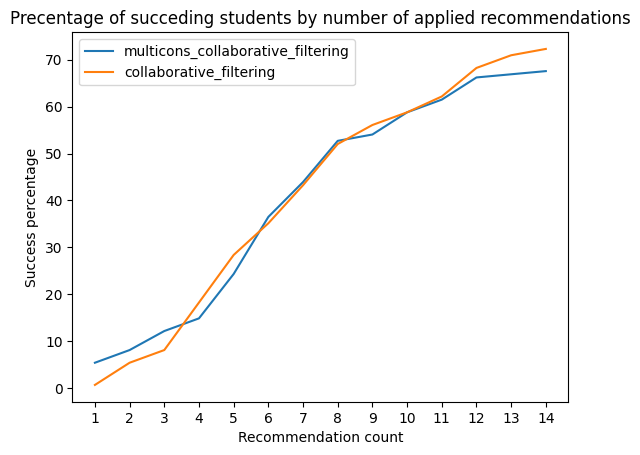

In [12]:
recommendation_improvement_rate_mc_cf_df.plot(
    title="Precentage of succeding students by number of applied recommendations",
    xlabel="Recommendation count",
    ylabel="Success percentage",
    xticks=recommendation_improvement_rate_mc_cf_df.index,
)
display()